
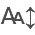

In [89]:
import networkx as nx
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

from scipy.stats import pearsonr 
from joblib import Parallel, delayed

# import urllib.request
import fastobo

import json

import goatools
from goatools.obo_parser import GODag

import itables.options as opt
from itables import init_notebook_mode, show
from itables.downsample import as_nbytes, nbytes
from itables.sample_dfs import get_indicators

init_notebook_mode(all_interactive=False)
opt.maxBytes = "128KB"

import seaborn as sns

sns.set()
plt.style.use('default')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from collections import Counter

import glob
import inspect


In [54]:
# plt.rcParams['figure.figsize'] = (15, 8)
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15
# plt.rcParams['legend.fontsize'] = 15
# plt.rcParams['axes.titlesize'] = 20

## Trabajo con la matriz de correlación 

In [90]:
matriz_pear = pd.read_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden.csv')
matriz_pear = matriz_pear.set_index('Proteina')
matriz_pear.head()

YAL001C   YAL002W   YAL003W   YAL004W   YAL005C   YAL007C  \
Proteina                                                               
YAL001C   1.000000  0.784409 -0.255929 -0.000721  0.124635 -0.135642   
YAL002W   0.784409  1.000000 -0.123425  0.319548  0.328560 -0.291349   
YAL003W  -0.255929 -0.123425  1.000000  0.547065  0.622235  0.410656   
YAL004W  -0.000721  0.319548  0.547065  1.000000  0.421385  0.195020   
YAL005C   0.124635  0.328560  0.622235  0.421385  1.000000  0.490343   

           YAL008W   YAL009W   YAL010C   YAL011W  ...   YPR194C   YPR195C  \
Proteina                                          ...                       
YAL001C   0.068274 -0.208016 -0.299033  0.302697  ...  0.110906  0.192338   
YAL002W  -0.001941 -0.428036 -0.446571  0.461013  ... -0.267790  0.156363   
YAL003W   0.247240 -0.175059 -0.003965  0.073686  ... -0.376035  0.005696   
YAL004W   0.078229 -0.540098 -0.166937  0.130986  ... -0.343021  0.282223   
YAL005C   0.529234 -0.297900 -0.515094  0.285265  ... -0.578441 -0.027009   

           YPR196W   YPR197C   YPR198W   YPR199C   YPR200C   YPR201W  \
Proteina                                                               
YAL001C   0.053657 -0.280936  0.393633 -0.057262 -0.237002  0.371669   
YAL002W   0.049744 -0.305974  0.368092 -0.187421 -0.604758  0.149767   
YAL003W  -0.300600  0.077396 -0.619781 -0.266689  0.030231 -0.170058   
YAL004W  -0.040569  0.437393 -0.452444 -0.556235 -0.384033  0.010244   
YAL005C   0.012542 -0.418005 -0.374103 -0.192349 -0.362241 -0.150002   

           YPR202W   YPR203W  
Proteina                      
YAL001C   0.053529  0.024929  
YAL002W   0.125068  0.234124  
YAL003W  -0.161563 -0.110182  
YAL004W   0.374832  0.544893  
YAL005C  -0.149757  0.049754  

[5 rows x 6217 columns]

In [91]:
enlaces = matriz_pear.copy().to_numpy()

enlaces[np.tril_indices_from(enlaces, k=-1)] = 0
df = pd.DataFrame(enlaces, columns=matriz_pear.columns, index=matriz_pear.index)
df.head()

YAL001C   YAL002W   YAL003W   YAL004W   YAL005C   YAL007C   YAL008W  \
Proteina                                                                        
YAL001C       1.0  0.784409 -0.255929 -0.000721  0.124635 -0.135642  0.068274   
YAL002W       0.0  1.000000 -0.123425  0.319548  0.328560 -0.291349 -0.001941   
YAL003W       0.0  0.000000  1.000000  0.547065  0.622235  0.410656  0.247240   
YAL004W       0.0  0.000000  0.000000  1.000000  0.421385  0.195020  0.078229   
YAL005C       0.0  0.000000  0.000000  0.000000  1.000000  0.490343  0.529234   

           YAL009W   YAL010C   YAL011W  ...   YPR194C   YPR195C   YPR196W  \
Proteina                                ...                                 
YAL001C  -0.208016 -0.299033  0.302697  ...  0.110906  0.192338  0.053657   
YAL002W  -0.428036 -0.446571  0.461013  ... -0.267790  0.156363  0.049744   
YAL003W  -0.175059 -0.003965  0.073686  ... -0.376035  0.005696 -0.300600   
YAL004W  -0.540098 -0.166937  0.130986  ... -0.343021  0.282223 -0.040569   
YAL005C  -0.297900 -0.515094  0.285265  ... -0.578441 -0.027009  0.012542   

           YPR197C   YPR198W   YPR199C   YPR200C   YPR201W   YPR202W   YPR203W  
Proteina                                                                        
YAL001C  -0.280936  0.393633 -0.057262 -0.237002  0.371669  0.053529  0.024929  
YAL002W  -0.305974  0.368092 -0.187421 -0.604758  0.149767  0.125068  0.234124  
YAL003W   0.077396 -0.619781 -0.266689  0.030231 -0.170058 -0.161563 -0.110182  
YAL004W   0.437393 -0.452444 -0.556235 -0.384033  0.010244  0.374832  0.544893  
YAL005C  -0.418005 -0.374103 -0.192349 -0.362241 -0.150002 -0.149757  0.049754  

[5 rows x 6217 columns]

In [57]:
# df.to_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden_superior.csv', header=True, index=True) #47seg en guardar la matriz triangular superior

In [92]:
adyacencia = matriz_pear.copy()

#originalmente cota en 0.5
cota = 0.9
# cota = 0.6
adyacencia[(matriz_pear >= -cota) & (matriz_pear <= cota)] = 0
adyacencia[(matriz_pear > cota) & (matriz_pear < 0.999999)] = 2
adyacencia[(matriz_pear < -cota)] = -2

adyacencia.head()

YAL001C  YAL002W  YAL003W  YAL004W  YAL005C  YAL007C  YAL008W  \
Proteina                                                                  
YAL001C       1.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL002W       0.0      1.0      0.0      0.0      0.0      0.0      0.0   
YAL003W       0.0      0.0      1.0      0.0      0.0      0.0      0.0   
YAL004W       0.0      0.0      0.0      1.0      0.0      0.0      0.0   
YAL005C       0.0      0.0      0.0      0.0      1.0      0.0      0.0   

          YAL009W  YAL010C  YAL011W  ...  YPR194C  YPR195C  YPR196W  YPR197C  \
Proteina                             ...                                       
YAL001C       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL002W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL003W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL004W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL005C       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

          YPR198W  YPR199C  YPR200C  YPR201W  YPR202W  YPR203W  
Proteina                                                        
YAL001C       0.0      0.0      0.0      0.0      0.0      0.0  
YAL002W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL003W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL004W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL005C       0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 6217 columns]

In [5]:
adyacencia.to_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden_adyacencia-'+str(cota)+'.csv', header=True, index=True)

### Trato de armar enlaces

In [93]:
adyacencia = pd.read_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden_adyacencia-'+str(cota)+'.csv')
adyacencia = adyacencia.set_index('Proteina')

In [94]:
adyacencia_sin_diagonal = adyacencia.copy()
np.fill_diagonal(adyacencia_sin_diagonal.values, 0)
adyacencia_sin_diagonal.head()

YAL001C  YAL002W  YAL003W  YAL004W  YAL005C  YAL007C  YAL008W  \
Proteina                                                                  
YAL001C       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL002W       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL003W       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL004W       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL005C       0.0      0.0      0.0      0.0      0.0      0.0      0.0   

          YAL009W  YAL010C  YAL011W  ...  YPR194C  YPR195C  YPR196W  YPR197C  \
Proteina                             ...                                       
YAL001C       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL002W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL003W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL004W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL005C       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

          YPR198W  YPR199C  YPR200C  YPR201W  YPR202W  YPR203W  
Proteina                                                        
YAL001C       0.0      0.0      0.0      0.0      0.0      0.0  
YAL002W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL003W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL004W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL005C       0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 6217 columns]

In [ ]:
def assign_edge_colors(G):
    edge_colors = {2: 'plum',
        -2: 'lightseagreen'}

    nx.set_edge_attributes(G, {e: edge_colors.get(G[e[0]][e[1]]['weight'], 'black') for e in G.edges()}, 'color')

In [62]:
#Le doy a todo
G = nx.from_pandas_adjacency(adyacencia_sin_diagonal)

# Asignar colores a las aristas
assign_edge_colors(G)

In [63]:
G.number_of_edges(), G.number_of_nodes()

(14359, 6217)

In [64]:
G2 = G.copy()

for u, v, data in G2.edges(data=True):
    if data['weight'] == -2.0 or data['weight'] == 2.0:
        data['weight'] = 1.0
        
# G2.edges(data=True)

In [65]:
# Tomo la componente gigante:

componentes = nx.connected_components(G2)
componentes = list(componentes)
componentes.sort(key=len, reverse=True)
componente_gigante = G2.subgraph(componentes[0])


In [66]:
componente_gigante.number_of_edges(), componente_gigante.number_of_nodes()

(13033, 1748)

In [67]:
# Ahora voy a probar armando 2 subgrafos, uno con las aristas de color rojo y otro con las aristas de color azul

G_positiva = G.copy()
G_negativa = G.copy()

for u, v, data in G.edges(data=True):
	if data['weight'] == -2.0:
		G_positiva.remove_edge(u, v)
	elif data['weight'] == 2.0:
		G_negativa.remove_edge(u, v)
                
#Cambio a peso 1 las aristas que quedaron
for u, v, data in G_positiva.edges(data=True):
	if data['weight'] == 2.0:
		data['weight'] = 1.0

for u, v, data in G_negativa.edges(data=True):
	if data['weight'] == -2.0:
		data['weight'] = 1.0

In [68]:
G_positiva.number_of_edges(), G_negativa.number_of_edges(), G.number_of_edges()

(11972, 2387, 14359)

In [40]:
def gigante(G):
	componentes = nx.connected_components(G)
	componentes = list(componentes)
	componentes.sort(key=len, reverse=True)
	componente_gigante = G.subgraph(componentes[0])
	return componente_gigante

In [69]:


# me quedo con la componente gigante de cada uno

gigante_pos = gigante(G_positiva)
gigante_neg = gigante(G_negativa)

## Abro archivo de interacciones entre proteinas

In [70]:
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

In [71]:
interacciones_apms = abrir_txt('/content/yeast_AP-MS.txt')
interacciones_apms[:10]

[['YAL001C', 'YBR123C'],
 ['YAL001C', 'YDR362C'],
 ['YAL001C', 'YGR047C'],
 ['YAL001C', 'YOR110W'],
 ['YAL001C', 'YPL007C'],
 ['YAL002W', 'YLR148W'],
 ['YAL002W', 'YLR396C'],
 ['YAL002W', 'YMR231W'],
 ['YAL002W', 'YPL045W'],
 ['YAL003W', 'YEL034W']]

In [72]:
apms = nx.Graph()
apms.add_edges_from(interacciones_apms)

apms.number_of_edges(), apms.number_of_nodes()

(9070, 1622)

In [73]:
common_edges_graph = nx.Graph()

# Iterar por las aristas de pos
for edge in gigante_pos.edges:
    if apms.has_edge(*edge):
        common_edges_graph.add_edge(*edge)


In [74]:
common_edges_graph.number_of_edges(), common_edges_graph.number_of_nodes()

(65, 71)

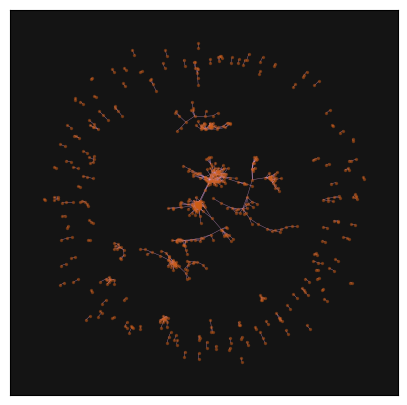

In [22]:
fig, axes = plt.subplots(1, 1, figsize = (5,5))

for i, ax in enumerate(fig.axes):
	# print(gigantes[i].number_of_edges())
	pos = nx.spring_layout(common_edges_graph, seed=42)
	edge_colors = nx.get_edge_attributes(common_edges_graph, 'color').values()
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(common_edges_graph,
						   pos = pos,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(common_edges_graph, pos = pos, ax = ax, alpha = .7, edge_color = 'plum', width = 0.3)


In [82]:
merged_graph = nx.Graph()

# Procesar las aristas de ambos grafos
for edge in gigante_pos.edges:
    if apms.has_edge(*edge):  # Pertenece a ambos
        merged_graph.add_edge(*edge, color='green')
    else:  # Solo pertenece a pos
        merged_graph.add_edge(*edge, color='blue')

for edge in apms.edges:
    if not gigante_pos.has_edge(*edge):  # Solo pertenece a apms
        merged_graph.add_edge(*edge, color='red')

# Ahora merged_graph contiene todas las aristas con los colores asignados


In [75]:
def plot_grafo(grafo):
	pos_layout = nx.spring_layout(grafo)  # Layout para la posición de los nodos
	edges = grafo.edges(data=True)

	fig, axes = plt.subplots(1, 1, figsize = (10,10))

	for i, ax in enumerate(fig.axes):
		pos = nx.spring_layout(grafo, seed=42)
		edge_colors = nx.get_edge_attributes(grafo, 'color').values()
		ax.set_facecolor('#141414') 
		nx.draw_networkx_nodes(grafo,
							pos = pos_layout,
							node_color = '#cc5c14',
							ax = ax,
							node_size = 2, alpha = 0.4)
		
		nx.draw_networkx_edges(grafo, pos = pos_layout, ax = ax, alpha = .7, edge_color = edge_colors, width = 0.3)

In [84]:
gigante_merge = gigante(merged_graph)
gigante_merge.number_of_edges(), gigante_merge.number_of_nodes()
# plot_grafo(gigante_merge)


(19258, 2437)

# Idea:
### Armar matriz de adyacencia en base a la red apms y sumar a cada elemento ij un 1 si existe correlacion positiva, y restar 0.5 si existe corr negativa

In [76]:
nodos_en_G = [node for node in apms.nodes if node in G]
cantidad_nodos_en_G = len(nodos_en_G)
cantidad_nodos_en_G

1598

In [77]:
G_positiva.number_of_nodes(), G_negativa.number_of_nodes(), G.number_of_nodes()

(6217, 6217, 6217)

In [78]:
red_pesada = nx.Graph()

for u, v in apms.edges():
    red_pesada.add_edge(u, v, weight=1)

for u, v in G_positiva.edges():
    if red_pesada.has_edge(u, v):
        red_pesada[u][v]['weight'] += 1
    else:
        # Si un enlace está en `G_positiva` pero no en `apms`, se agrega con peso 1
        red_pesada.add_edge(u, v, weight=0.3)

for u, v in G_negativa.edges():
    if red_pesada.has_edge(u, v):
        red_pesada[u][v]['weight'] -= 0.5
    else:
        # Si un enlace está solo en `G_negativa`, puedes agregarlo con peso negativo, o ignorarlo
        red_pesada.add_edge(u, v, weight=0.1)

print("Número de nodos en la red pesada:", red_pesada.number_of_nodes())
print("Número de enlaces en la red pesada:", red_pesada.number_of_edges())

# Filtrar enlaces con pesos negativos o nulos en caso de que los haya
enlaces_a_remover = [(u, v) for u, v, data in red_pesada.edges(data=True) if data['weight'] <= 0]
red_pesada.remove_edges_from(enlaces_a_remover)

print("Red final:")
print("Número de nodos:", red_pesada.number_of_nodes())

Número de nodos en la red pesada: 3287
Número de enlaces en la red pesada: 23352
Red final:
Número de nodos: 3287


In [14]:
# Obtener pesos de los enlaces
pesos = [data['weight'] for _, _, data in red_pesada.edges(data=True)]

# Definir los colores según el peso
def asignar_color(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	else:
		return 'red'  # Opcional, para pesos no especificados
	
def asignar_colores_full(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	elif peso == 0.3:
		return colores_tuple[3]
	elif peso == 0.1:
		return colores_tuple[4]
	else:
		return 'red'  # Opcional, para pesos no especificados
	
# Asignar colores basados en los pesos
colores = [asignar_color(p, colores_tuple = ('white', 'plum', 'lightseagreen')) for p in pesos]


In [15]:
def edge_colors_funcion(red_pesada, colores_tuple = ('white', 'plum', 'lightseagreen')):
    # Obtener pesos de los enlaces
	pesos = [data['weight'] for _, _, data in red_pesada.edges(data=True)]

	# Asignar colores basados en los pesos
	if len(colores_tuple) == 3:
		colores = [asignar_color(p, colores_tuple) for p in pesos]
	else:
		colores = [asignar_colores_full(p, colores_tuple) for p in pesos]

	return colores

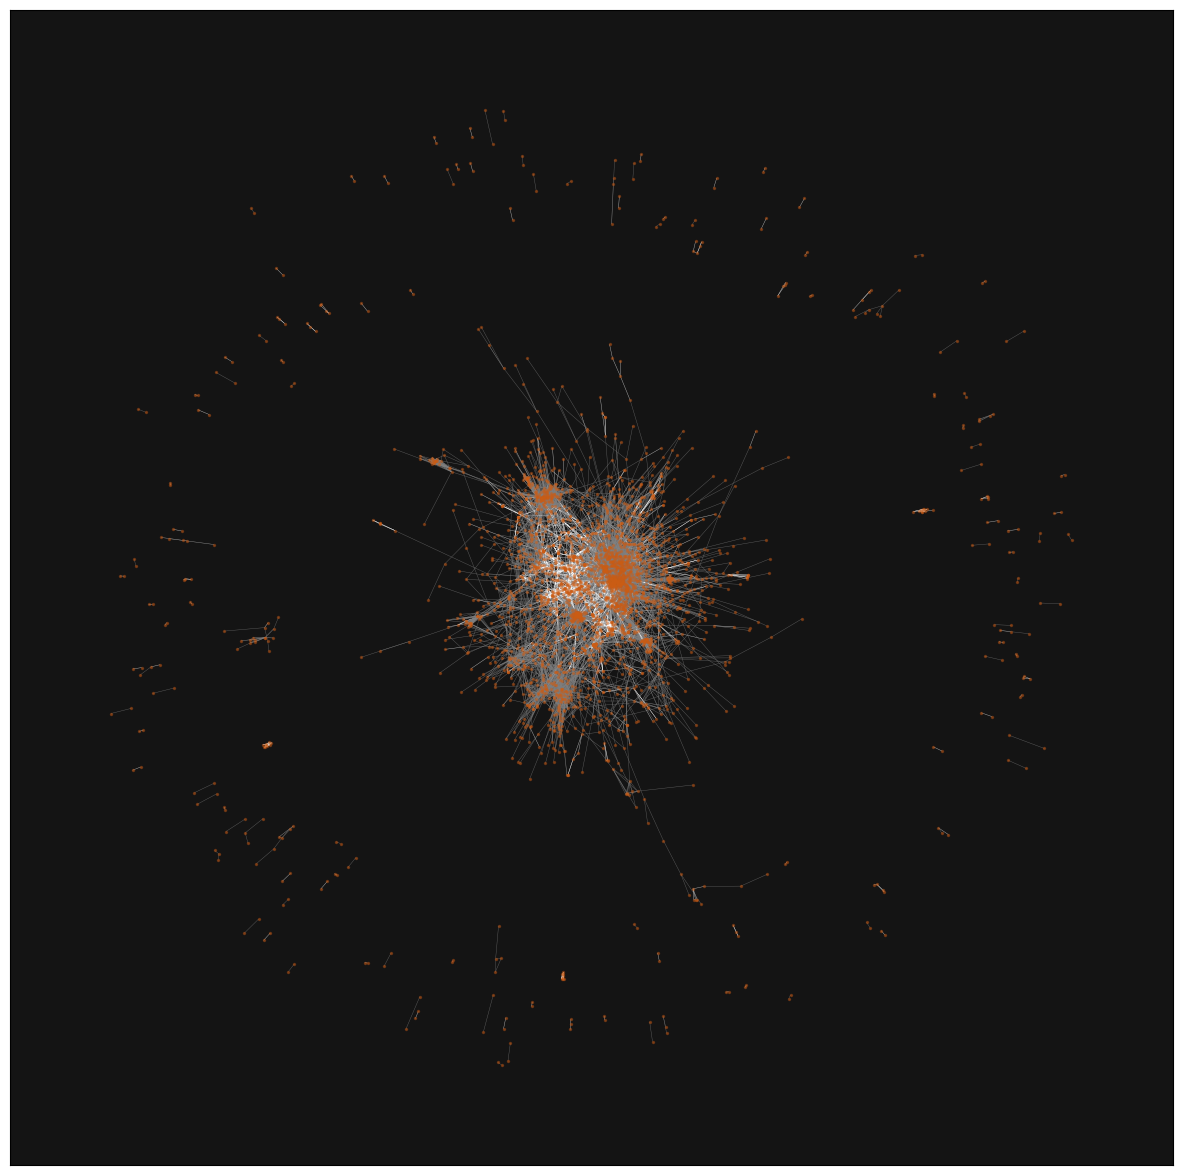

In [91]:
# Dibujar el grafo
pos_layout = nx.spring_layout(red_pesada)  # Layout para la posición de los nodos
edges = red_pesada.edges(data=True)

fig, axes = plt.subplots(1, 1, figsize = (15,15))

for i, ax in enumerate(fig.axes):
	# print(gigantes[i].number_of_edges())
	pos = nx.spring_layout(red_pesada, seed=42)
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(red_pesada,
						   pos = pos_layout,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(red_pesada, pos = pos_layout, ax = ax, alpha = .7, edge_color = colores, width = 0.3)

In [81]:
gigante_red_pesada = gigante(red_pesada)

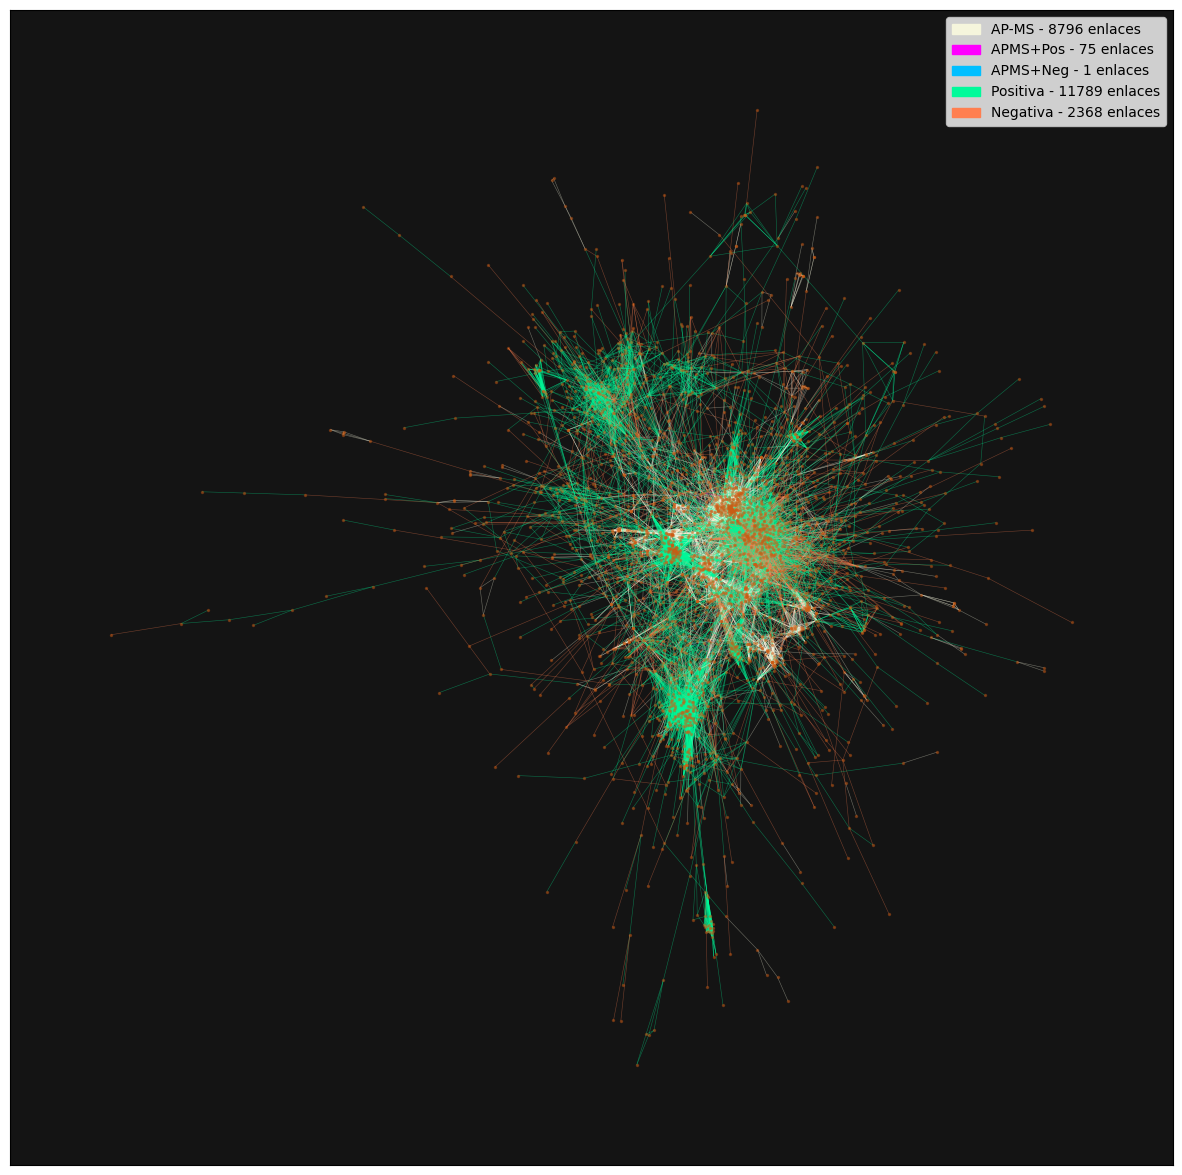

In [110]:
edges = gigante_red_pesada.edges(data=True)

colores_tuple = ('beige', 'magenta', 'deepskyblue', 'mediumspringgreen', 'coral')

colores = edge_colors_funcion(gigante_red_pesada, colores_tuple = colores_tuple)
conteo = Counter(colores)
conteo


pos_layout = nx.spring_layout(gigante_red_pesada, seed=42)  # Layout para la posición de los nodos

fig, axes = plt.subplots(1, 1, figsize = (15,15))

for i, ax in enumerate(fig.axes):
	pos = nx.spring_layout(gigante_red_pesada, seed=42)
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(gigante_red_pesada,
						   pos = pos_layout,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(gigante_red_pesada, pos = pos_layout, ax = ax, alpha = .4, edge_color = colores, width = 0.4)

if len(colores_tuple) == 5:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[3], label='Positiva - ' + str(conteo[colores_tuple[3]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[4], label='Negativa - ' + str(conteo[colores_tuple[4]]) + ' enlaces')], loc='upper right')
else:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces')], loc='upper right')


In [82]:
conteo = Counter(colores)
conteo

Counter({'white': 8993, 'gray': 14282, 'plum': 76, 'lightseagreen': 1})

In [111]:
nx.write_gpickle(red_pesada, 'red_pesada-cota09+full.gpickle')

In [112]:
red_pesada.number_of_edges(), red_pesada.number_of_nodes()

(23352, 3287)

# Voy a intentar aplicar los algoritmos de similaridad para armar clusters

#### Con matriz de adyacencia 0.9 + full

In [2]:
import igraph as ig
from community import community_louvain as com
import random

In [196]:
# red_pesada.edges(data=True)

In [ ]:
# # Devuelta armo subset de nodos que estan en la red pesada para testeo

# prueba = red_pesada.copy()

# # Seleccionar 500 enlaces aleatorios del grafo principal
# enlaces = list(red_pesada.edges(data=True))
# enlaces_prueba = random.sample(enlaces, 1500)

# # Crear la subred con esos enlaces
# prueba = nx.Graph()
# prueba.add_edges_from(enlaces_prueba)


In [47]:
# colores_tuple = ('beige', 'magenta', 'deepskyblue', 'mediumspringgreen', 'coral')

# colores = edge_colors_funcion(prueba, colores_tuple = colores_tuple)
# nx.draw_spring(prueba, node_size=2, edge_color=colores, node_color = 'k', with_labels=False)

In [3]:
# Louivan
red_pesada = nx.read_gpickle('red_pesada-cota09+full.gpickle')
com_lv = com.best_partition(red_pesada, weight='weight')

In [4]:
print('Louvain')
print(f'La cantidad de comunas que maximiza la modularidad es: {max(com_lv.values()) + 1}')
print(f'La modularidad de dicha partición es: {com.modularity(com_lv, red_pesada)}')
# Agrupamos los nodos por comunidad
comunidades = {}
for nodo, comunidad in com_lv.items():
	if comunidad not in comunidades:
		comunidades[comunidad] = []
	comunidades[comunidad].append(nodo)

# Imprimimos las comunidades en el formato solicitado
for comunidad, nodos in comunidades.items():
	print(f'[{comunidad}] {", ".join(nodos)}')

Louvain
La cantidad de comunas que maximiza la modularidad es: 179
La modularidad de dicha partición es: 0.7999200094259913
[0] YAL001C, YBR123C, YDR362C, YGR047C, YOR110W, YPL007C, YNL209W, YDL018C, YAL024C, YHR158C, YGR238C, YPR174C, YNL233W, YAL047C, YHR172W, YNL126W, YLR212C, YJL173C, YAR007C, YHR164C, YML032C, YNL312W, YOL090W, YBR136W, YCR028CA, YDL156W, YER104W, YCR092C, YDR097C, YJL115W, YCL024W, YDR507C, YBL035C, YIR008C, YKL045W, YNL102W, YPL208W, YPL153C, YBR087W, YJR068W, YNL290W, YOL094C, YOR144C, YMR078C, YBR135W, YBR160W, YDL155W, YKR091W, YLR079W, YMR199W, YPL256C, YLR210W, YBR195C, YML102W, YPR018W, YDR121W, YBR278W, YNL262W, YPR175W, YCL016C, YHR191C, YDL003W, YFL008W, YJL074C, YHR110W, YDL056W, YLR182W, YER111C, YDL102W, YJR006W, YJR043C, YDR013W, YJL072C, YOL146W, YDR489W, YDR016C, YDR201W, YGL061C, YKL052C, YGR113W, YKR083C, YDR279W, YNL072W, YER149C, YLL021W, YLL002W, YNL246W, YLR035C, YMR167W, YNL082W, YLR386W, YNL325C, YMR048W, YNL273W, YDL095W, YAL038W, YBR151W

In [186]:
red_pesada.number_of_nodes()

3287

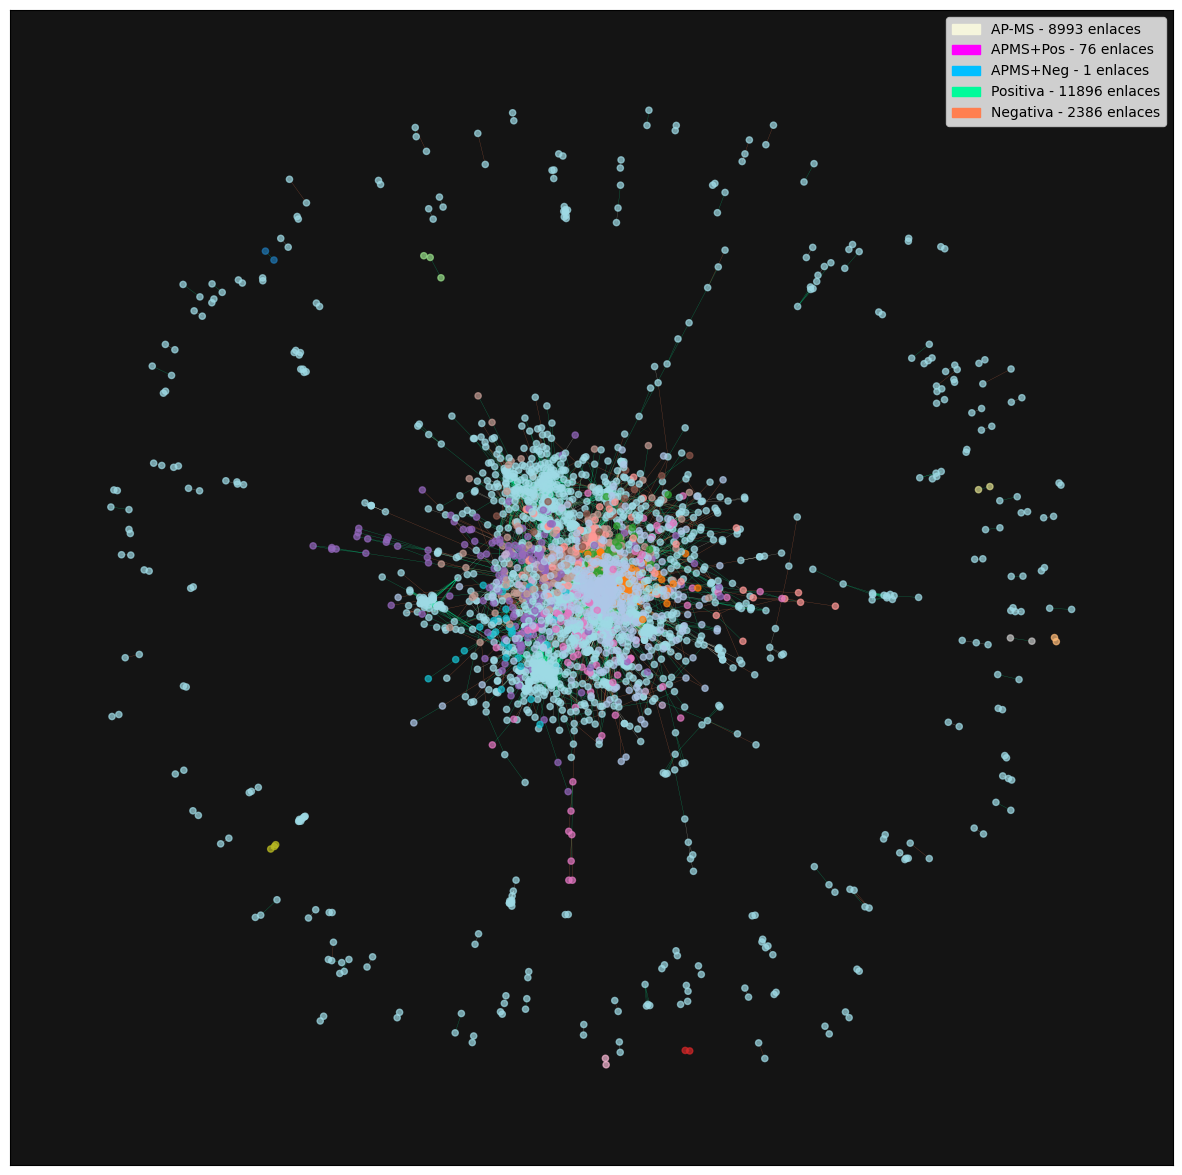

In [187]:
# Red clusterizada

# Creo un diccionario con los nombres de los nodos como keys y los clusters como values
pos = nx.layout.spring_layout(red_pesada, seed=42)
colores = edge_colors_funcion(red_pesada, colores_tuple = colores_tuple)
conteo = Counter(colores)

fig, axs = plt.subplots(1, 1, figsize = (15, 15))

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(red_pesada,
						   pos = pos,
						   node_color = [plt.get_cmap('tab20')(com_lv[v]) for v in red_pesada.nodes()],
						   ax = ax,
						   node_size = 20, alpha = 0.7)
	nx.draw_networkx_edges(red_pesada, pos = pos, ax = ax, alpha = .5, edge_color = colores, width = 0.2)
	ax.axis('on')

	ax.legend('Louivan', loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

if len(colores_tuple) == 5:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[3], label='Positiva - ' + str(conteo[colores_tuple[3]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[4], label='Negativa - ' + str(conteo[colores_tuple[4]]) + ' enlaces')], loc='upper right')
else:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces')], loc='upper right')
	
	plt.tight_layout()

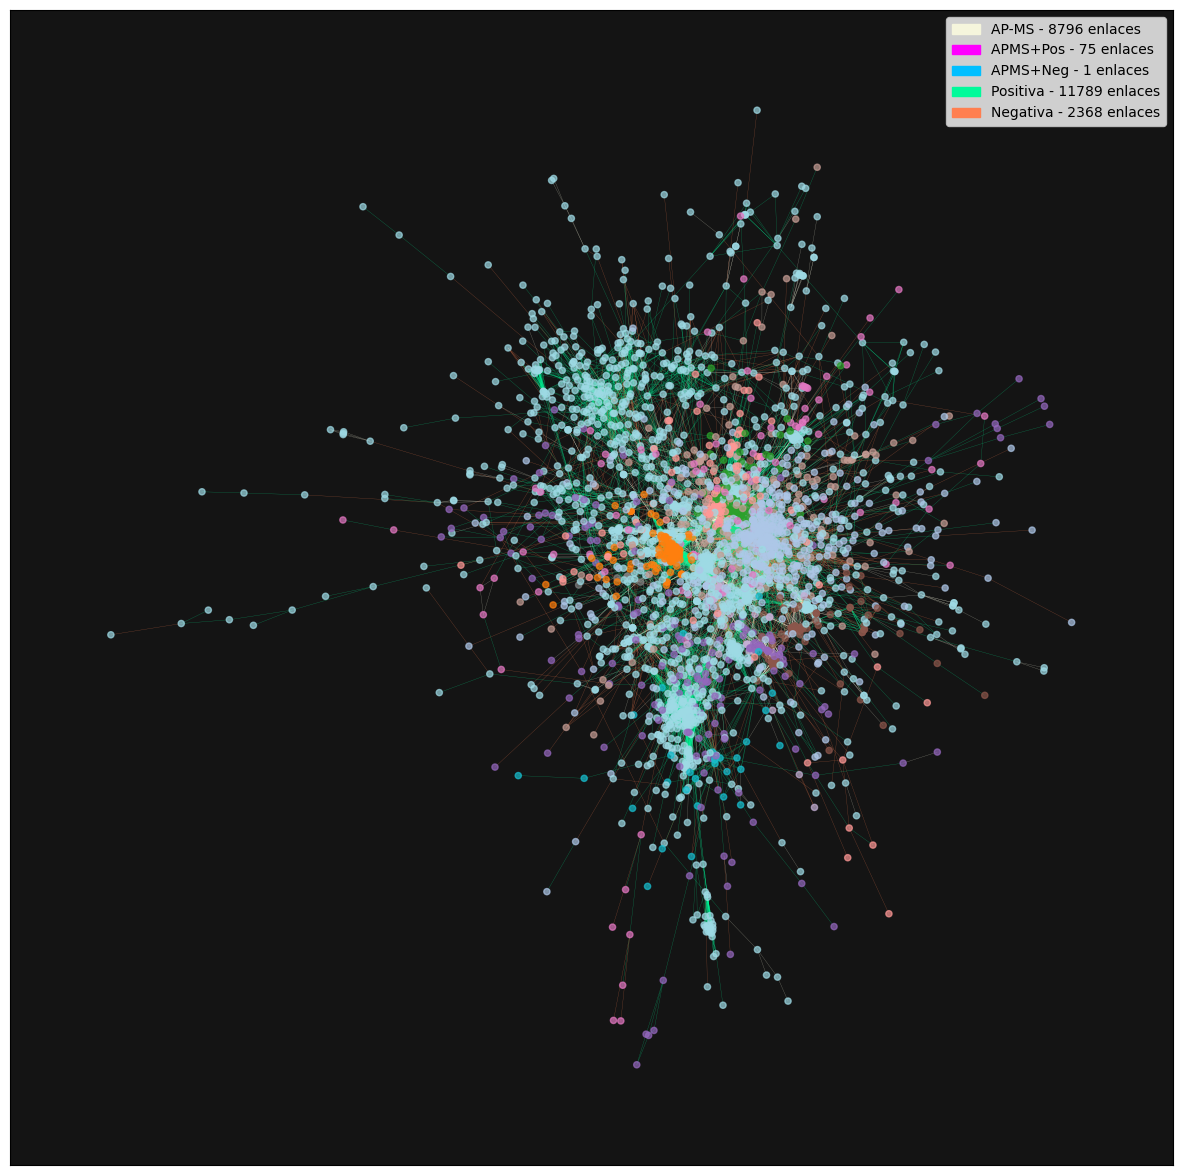

In [189]:
gigante_prueba = gigante(red_pesada)

pos = nx.layout.spring_layout(gigante_prueba, seed=42)
colores = edge_colors_funcion(gigante_prueba, colores_tuple = colores_tuple)
conteo = Counter(colores)

fig, axs = plt.subplots(1, 1, figsize = (15, 15))

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(gigante_prueba,
						   pos = pos,
						   node_color = [plt.get_cmap('tab20')(com_lv[v]) for v in gigante_prueba.nodes()],
						   ax = ax,
						   node_size = 20, alpha = 0.7)
	nx.draw_networkx_edges(gigante_prueba, pos = pos, ax = ax, alpha = .5, edge_color = colores, width = 0.2)
	ax.axis('on')

	ax.legend('Louivan', loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

if len(colores_tuple) == 5:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[3], label='Positiva - ' + str(conteo[colores_tuple[3]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[4], label='Negativa - ' + str(conteo[colores_tuple[4]]) + ' enlaces')], loc='upper right')
else:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces')], loc='upper right')
	
	plt.tight_layout()

### Con matriz de adyacencia 0.6

In [6]:
red_pesada = nx.read_gpickle('red_pesada-cota06.gpickle')
# print(red_pesada.edges(data=True))

In [7]:
# Louivan
com_lv = com.best_partition(red_pesada, weight='weight', resolution = 0.7)

# print('Louvain')
print(f'La cantidad de comunas que maximiza la modularidad es: {max(com_lv.values()) + 1}')

print(f'La modularidad de dicha partición es: {com.modularity(com_lv, red_pesada)}')
# Agrupamos los nodos por comunidad
comunidades = {}
for nodo, comunidad in com_lv.items():
	if comunidad not in comunidades:
		comunidades[comunidad] = []
	comunidades[comunidad].append(nodo)

# Imprimimos las comunidades en el formato solicitado
for comunidad, nodos in comunidades.items():
	print(f'[{comunidad}] {", ".join(nodos)}')

La cantidad de comunas que maximiza la modularidad es: 212
La modularidad de dicha partición es: 0.7891214534163487
[0] YAL001C, YBR123C, YDR362C, YGR047C, YOR110W, YPL007C
[1] YAL002W, YLR148W, YLR396C, YMR231W, YPL045W, YDL077C, YDR080W
[5] YAL003W, YEL034W, YGR285C, YHR064C, YKL081W, YLR249W, YPL048W, YNL209W, YBR025C, YBR118W, YPR080W, YBR196C, YDR381W, YDR385W, YLL026W, YLR044C, YMR186W, YOL086C, YOR133W, YOR136W, YAL026C, YLR447C, YGR020C, YKL119C, YOR270C, YBR017C, YEL022W, YGL195W, YLR180W, YBL071WA, YIL103W, YKL191W, YDL084W, YDR138W, YHR167W, YML062C, YNL139C, YNL253W, YBL099W, YJR121W, YDL185W, YGL122C, YJR077C, YOR160W, YGR218W, YHR020W, YMR012W, YKL182W, YBR127C, YEL051W, YFR009W, YHR039CA, YJR033C, YKL080W, YOR332W, YPR036W, YDL143W, YDR214W, YFL045C, YIL094C, YKL029C, YKL104C, YBR072W, YNL064C, YDR202C, YDR171W, YGL245W, YCR012W, YHR174W, YKL060C, YDR127W, YOR027W, YPL240C, YDR050C, YMR083W, YMR303C, YNL004W, YGR192C, YKL152C, YDL112W, YPL231W, YDR328C, YKR014C, YMR258C,

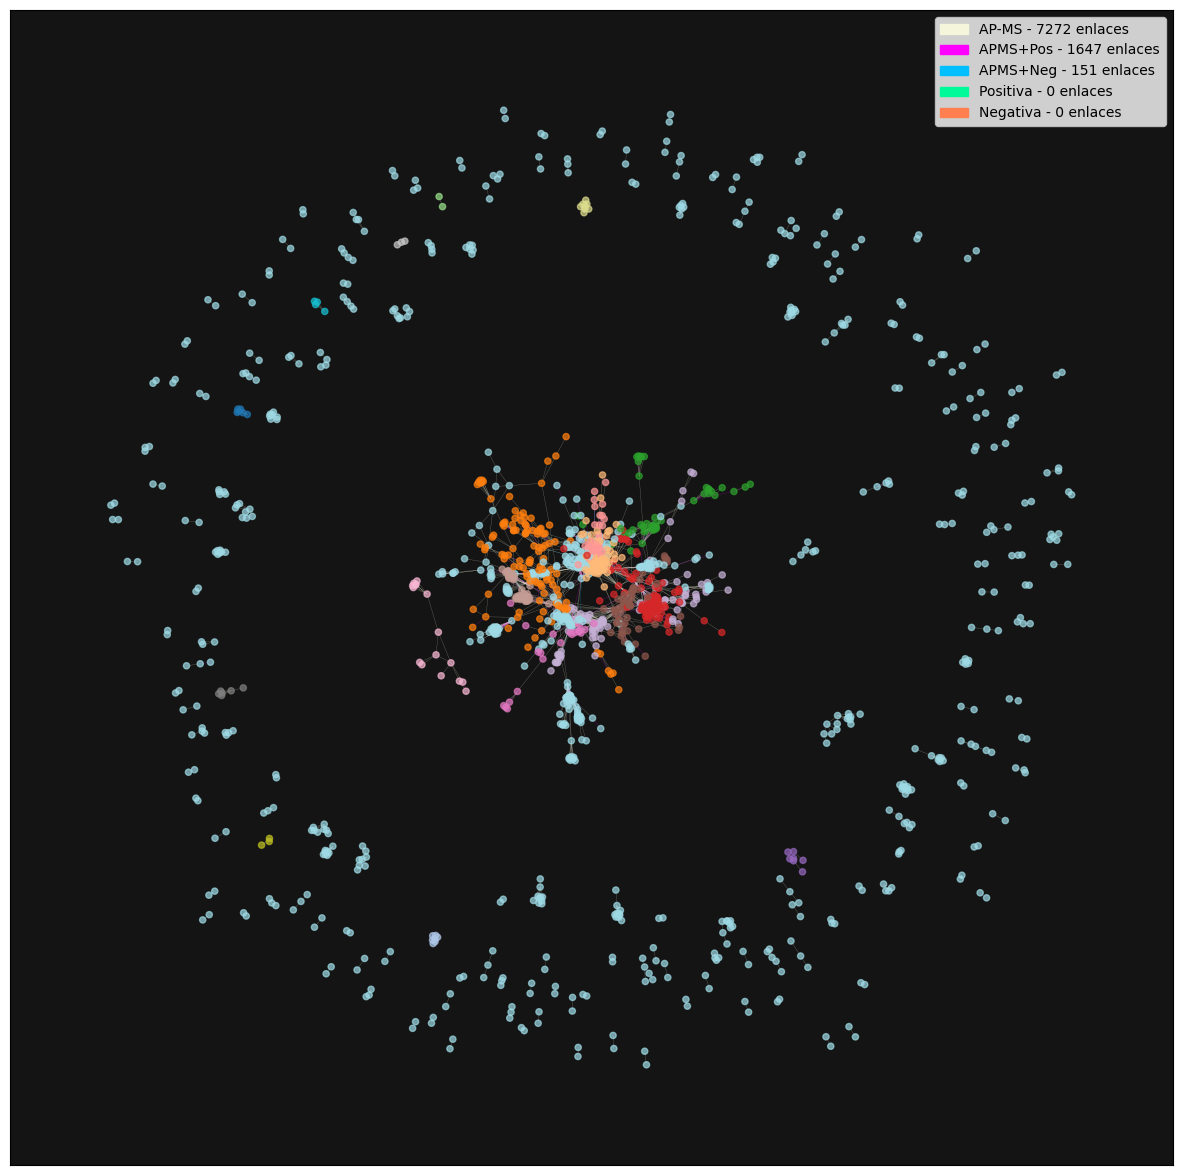

In [ ]:
# Red clusterizada

# Creo un diccionario con los nombres de los nodos como keys y los clusters como values
pos = nx.layout.spring_layout(red_pesada, seed=42)
colores = edge_colors_funcion(red_pesada, colores_tuple = colores_tuple)
conteo = Counter(colores)

fig, axs = plt.subplots(1, 1, figsize = (15, 15))

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(red_pesada,
						   pos = pos,
						   node_color = [plt.get_cmap('tab20')(com_lv[v]) for v in red_pesada.nodes()],
						   ax = ax,
						   node_size = 20, alpha = 0.7)
	nx.draw_networkx_edges(red_pesada, pos = pos, ax = ax, alpha = .5, edge_color = colores, width = 0.2)
	ax.axis('on')

	ax.legend('Louivan', loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

if len(colores_tuple) == 5:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[3], label='Positiva - ' + str(conteo[colores_tuple[3]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[4], label='Negativa - ' + str(conteo[colores_tuple[4]]) + ' enlaces')], loc='upper right')
else:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces')], loc='upper right')
	
	plt.tight_layout()

In [8]:
colores_tuple = ('beige', 'magenta', 'deepskyblue', 'mediumspringgreen', 'coral')

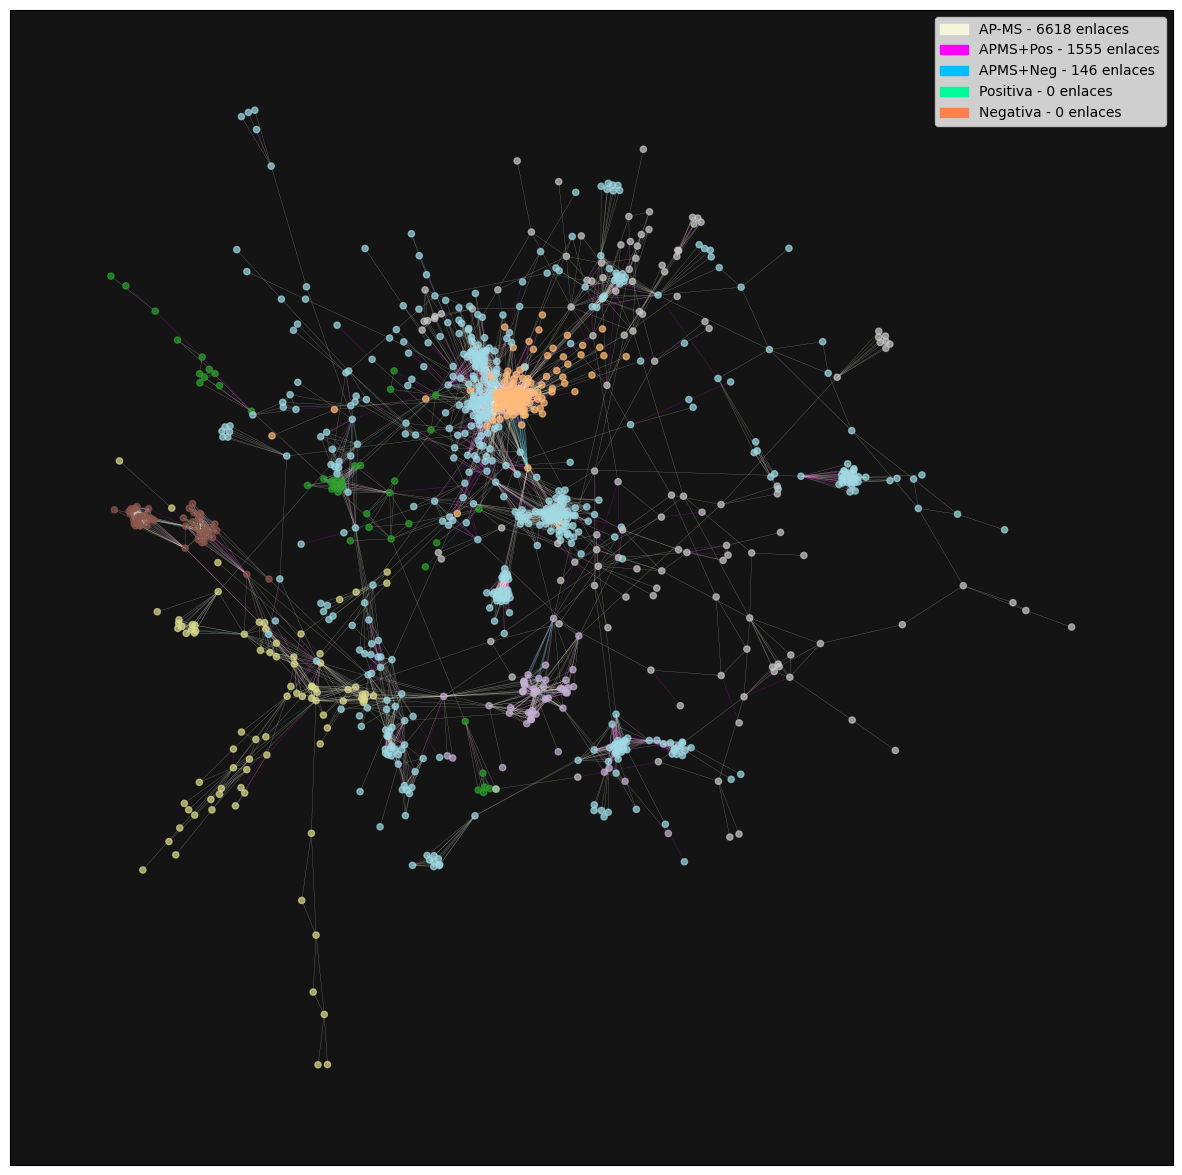

In [131]:
gigante_prueba = gigante(red_pesada)

pos = nx.layout.spring_layout(gigante_prueba, seed=42)
colores = edge_colors_funcion(gigante_prueba, colores_tuple = colores_tuple)
conteo = Counter(colores)

fig, axs = plt.subplots(1, 1, figsize = (15, 15))

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(gigante_prueba,
						   pos = pos,
						   node_color = [plt.get_cmap('tab20')(com_lv[v]) for v in gigante_prueba.nodes()],
						   ax = ax,
						   node_size = 20, alpha = 0.7)
	nx.draw_networkx_edges(gigante_prueba, pos = pos, ax = ax, alpha = .5, edge_color = colores, width = 0.2)
	ax.axis('on')

	ax.legend('Louivan', loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

if len(colores_tuple) == 5:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[3], label='Positiva - ' + str(conteo[colores_tuple[3]]) + ' enlaces'),
						mpatches.Patch(color=colores_tuple[4], label='Negativa - ' + str(conteo[colores_tuple[4]]) + ' enlaces')], loc='upper right')
else:
	plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
						mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces')], loc='upper right')
	
	plt.tight_layout()

In [ ]:
# import json

# # Guardar la partición como un archivo JSON
# with open("particion_louvain.json", "w") as f:
#     json.dump(com_lv, f)

# # Leer la partición desde el archivo
# with open("particion_louvain.json", "r") as f:
#     partition_cargada = json.load(f)


In [10]:
######## Creo los N subgrafos:

# Ejecutar Louvain en la red
partition = com.best_partition(red_pesada, weight='weight', resolution=0.7)

# Crear un diccionario para agrupar nodos por comunidad
comunidades = {}
for nodo, comunidad in partition.items():
    if comunidad not in comunidades:
        comunidades[comunidad] = []
    comunidades[comunidad].append(nodo)

# Crear subgrafos por comunidad y guardar
subgrafos = {}
for comunidad, nodos in comunidades.items():
    subgrafo = red_pesada.subgraph(nodos).copy()
    subgrafos[comunidad] = subgrafo

    # Guardar cada subgrafo en formato GraphML (o el formato deseado)
    nx.write_graphml(subgrafo, f"../../Datos/subgrafos/subgrafo_comunidad_{comunidad}.graphml")


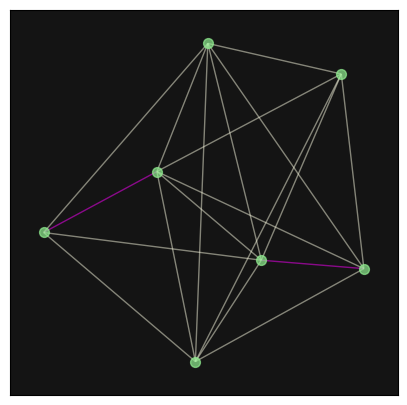

In [17]:
sub1 = nx.read_graphml('../../Datos/subgrafos/subgrafo_comunidad_1.graphml')
# len(sub1.edges(data=True))
colores_tuple = ('beige', 'magenta', 'deepskyblue', 'mediumspringgreen', 'coral')

pos = nx.spring_layout(sub1, seed=42)

fig, axs = plt.subplots(1, 1, figsize = (5, 5))

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(sub1,
						   pos = pos,
						   node_color = 'lightgreen',
						   ax = ax,
						   node_size = 50, alpha = 0.7)
	nx.draw_networkx_edges(sub1, pos = pos, ax = ax, alpha = .5, edge_color = edge_colors_funcion(sub1, colores_tuple = colores_tuple), width = 1)
	ax.axis('on')

## Voy a tomar solo la componente gigante para armar comunidades

De lo contrario tengo muchas que son solo de 2 nodos

In [68]:
def aplicar_louivan(red, resolucion = 1):# Louivan
	com_lv = com.best_partition(red, weight='weight', resolution = resolucion)

	# print('Louvain')
	print(f'La cantidad de comunas que maximiza la modularidad es: {max(com_lv.values()) + 1}')

	print(f'La modularidad de dicha partición es: {com.modularity(com_lv, red)}')
	# # Agrupamos los nodos por comunidad
	# comunidades = {}
	# for nodo, comunidad in com_lv.items():
	# 	if comunidad not in comunidades:
	# 		comunidades[comunidad] = []
	# 	comunidades[comunidad].append(nodo)

	# # Imprimimos las comunidades en el formato solicitado
	# for comunidad, nodos in comunidades.items():
	# 	print(f'[{comunidad}] {", ".join(nodos)}')

	return com_lv

In [69]:
# for i in np.linspace(0.1, 2, 20):
# 	print('Resolución:', i)
# 	aplicar_louivan(red_pesada, resolucion = i)

In [70]:
# guardo las particiones
def guardar_louivan(red, path, resolucion = 1):
	partition = aplicar_louivan(red, resolucion = resolucion)

	# Crear un diccionario para agrupar nodos por comunidad
	comunidades = {}
	for nodo, comunidad in partition.items():
		if comunidad not in comunidades:
			comunidades[comunidad] = []
		comunidades[comunidad].append(nodo)

	# Crear subgrafos por comunidad y guardar
	subgrafos = {}
	for comunidad, nodos in comunidades.items():
		subgrafo = red.subgraph(nodos).copy()
		subgrafos[comunidad] = subgrafo

		# Guardar cada subgrafo en formato GraphML (o el formato deseado)
		nx.write_graphml(subgrafo, path+f"/subgrafo_comunidad_{comunidad}.graphml")

In [71]:
def gigante(G):
	componentes = nx.connected_components(G)
	componentes = list(componentes)
	componentes.sort(key=len, reverse=True)
	componente_gigante = G.subgraph(componentes[0])
	return componente_gigante


In [72]:
red_pesada = nx.read_gpickle('red_pesada-cota06.gpickle')
red_evaluar = gigante(red_pesada)
guardar_louivan(red_evaluar, '../../Datos/subgrafos/Gigante_06', 1)
# partition = aplicar_louivan(red_pesada, resolucion = 1)
# red_pesada.edges(data=True)


La cantidad de comunas que maximiza la modularidad es: 23
La modularidad de dicha partición es: 0.7600337068337397


In [27]:
red_pesada.number_of_nodes()

1622

In [73]:
def asignar_colores_full(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	elif peso == 0.3:
		return colores_tuple[3]
	elif peso == 0.1:
		return colores_tuple[4]
	else:
		return 'red'  # Opcional, para pesos no especificados
		

def edge_colors_funcion(red_pesada, colores_tuple = ('white', 'plum', 'lightseagreen')):
    # Obtener pesos de los enlaces
	pesos = [data['weight'] for _, _, data in red_pesada.edges(data=True)]

	# Asignar colores basados en los pesos
	if len(colores_tuple) == 3:
		colores = [asignar_color(p, colores_tuple) for p in pesos]
	else:
		colores = [asignar_colores_full(p, colores_tuple) for p in pesos]

	return colores

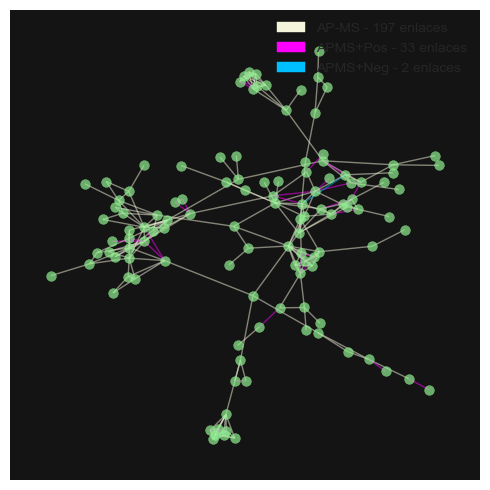

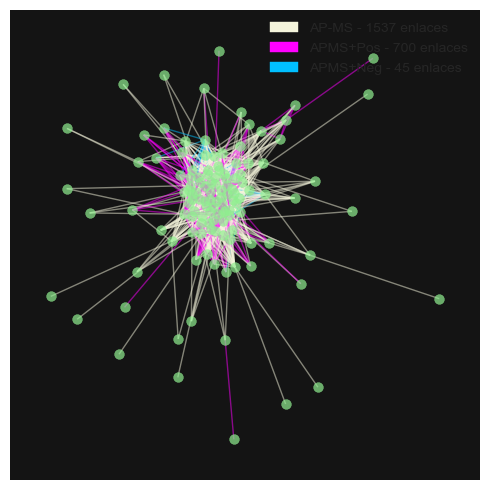

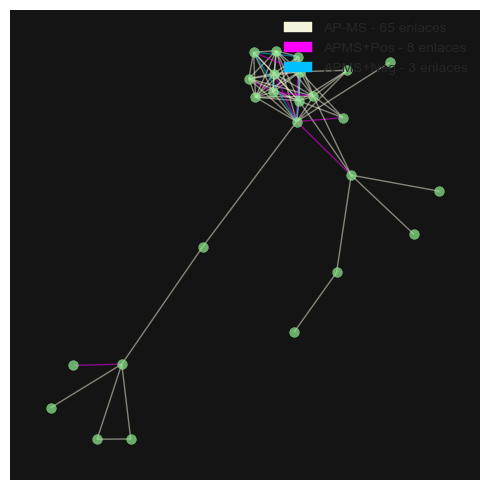

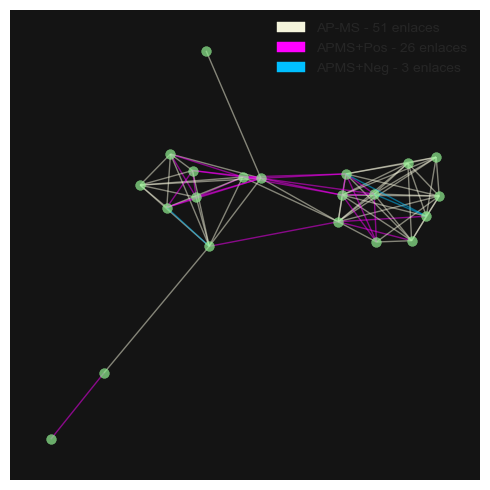

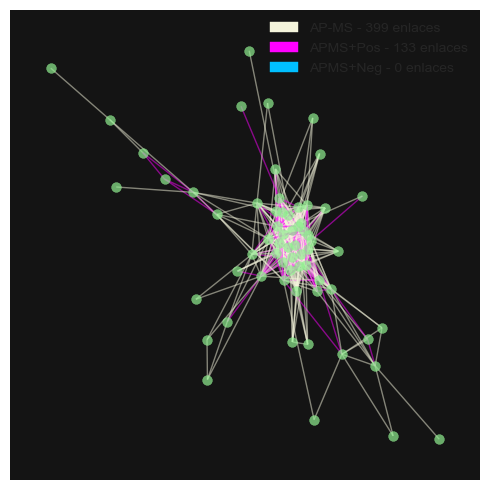

In [75]:
# Aplico a cada subred lo del tp3:

# primero los miro:

grafitos = sorted(list(glob.glob('../../Datos/subgrafos/Gigante_06/subgrafo_comunidad_*.graphml')))
# grafitos
for grafo in grafitos[:5]:
	sub1 = nx.read_graphml(grafo)
	# len(sub1.edges(data=True))
	colores_tuple = ('beige', 'magenta', 'deepskyblue', 'green', 'coral')
	colores = edge_colors_funcion(sub1, colores_tuple = colores_tuple)
	conteo = Counter(colores)

	pos = nx.spring_layout(sub1, seed=42)

	fig, axs = plt.subplots(1, 1, figsize = (5,5))

	for i, ax in enumerate(fig.axes):
		ax.set_facecolor('#141414')  # Cambiar color de background
		nx.draw_networkx_nodes(sub1,
							pos = pos,
							node_color = 'lightgreen',
							ax = ax,
							node_size = 50, alpha = 0.7)
		nx.draw_networkx_edges(sub1, pos = pos, ax = ax, alpha = .5, edge_color = colores, width = 1)
		ax.axis('on')
		plt.legend(handles=[mpatches.Patch(color=colores_tuple[0], label='AP-MS - ' + str(conteo[colores_tuple[0]]) + ' enlaces'), 
							mpatches.Patch(color=colores_tuple[1], label='APMS+Pos - ' + str(conteo[colores_tuple[1]]) + ' enlaces'), 
							mpatches.Patch(color=colores_tuple[2], label='APMS+Neg - ' + str(conteo[colores_tuple[2]]) + ' enlaces')], loc='upper right')
			
		plt.tight_layout()
		plt.grid(False)

#### Aplicacion pura

In [32]:
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

In [77]:
def abrir_esenciales(nombre_archivo):
    archivo = open(nombre_archivo)
    data = []
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    data = data[2:]
    esenciales = []
    for linea in data:
      if len(linea)>2:
        esenciales.append(linea[1])
    return(esenciales)

Data_esenciales = abrir_txt('../TP3/TC03_data/Essential_ORFs_paperHe.txt')
print(Data_esenciales)

lista_esenciales = abrir_esenciales('../TP3/TC03_data/Essential_ORFs_paperHe.txt')
print (lista_esenciales)

[['rec_num', 'ORF_name', 'deletion_alias', 'gene_names', 'UPTAG_sequence_20mer', 'DNTAG_sequence_20mer'], ['=====', '=========', '==============', '=====================================================', '====================', '===================='], ['20406', 'YAL001C', 'TSV115,', 'FUN24', 'ACTATATGTGAAGGCATGGC'], ['20404', 'YAL003W', 'TEF5', 'GACATATCAGCATACATGGC'], ['20383', 'YAL025C', 'TGCCGCATCAAAGAGGCCAA'], ['20376', 'YAL032C', 'FUN20', 'TGATCCGCGTCGATGCTCTT'], ['20375', 'YAL033W', 'FUN53', 'CTGACTTAGTGCATACTGCT'], ['20372', 'YAL034W-a', 'NSL2,', 'DSN3', 'GGACCTCTGCTCATTATGCT'], ['20373', 'YAL035C-A', 'ATTGGTCACTCTGCACTGCT'], ['20368', 'YAL038W', 'PYK1', 'ATTGAGAGTCAGTGCCAGAT'], ['20365', 'YAL041W', 'CLS4', 'TATGGACTGGCATCACCGTG'], ['20362', 'YAL043C', 'FUN39', 'AGTCCATGCAGCACTCTTGG'], ['20409', 'YAR007C', 'RPA1,', 'FUN3,', 'BUF2', 'GCAGTGCGTGAACCTCTATC'], ['20410', 'YAR008W', 'FUN4', 'CATGAGAGTGAAGCAGTATC'], ['20416', 'YAR019C', 'LYT1', 'GCGCTTATCACATTTGACAG'], ['23028', 'YBL0

In [78]:
def segundo_elemento(lista):
  return lista[1]

def hacer_lista_grados_ordenada(Red):
  grados = Red.degree()
  grados = list(grados)
  grados.sort(key = segundo_elemento, reverse = True)
  return [nodo for (nodo,grado) in grados]

def ordenar_diccionario_por_valor(diccionario):
  return [key for key, value in sorted(diccionario.items(), key=lambda item: item[1], reverse=True)]

def armar_componente_gigante(Red):
  Conjunto_nodos_en_gigante = max(nx.connected_components(Red), key=len)
  Componente_Gigante = Red.subgraph(Conjunto_nodos_en_gigante).copy()
  return Componente_Gigante

In [79]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var][0]

In [80]:
def elementos_tabla(Red):
	# Me quedo solo con la componente gigante
	Red_gigante = armar_componente_gigante(Red)

	nodos = Red_gigante.number_of_nodes()
	enlaces = Red_gigante.number_of_edges()
	promedio_grados = np.mean([grado for (nodo,grado) in list(Red_gigante.degree())])
	clustering = nx.average_clustering(Red_gigante)
	
	return (nodos,enlaces,promedio_grados,clustering)

In [81]:
tabla1 = pd.DataFrame(columns = ['Comunidad', 'Nodos', 'Enlaces', 'Grado promedio', 'Coeficiente de clustering'])
grafitos = sorted(list(glob.glob('../../Datos/subgrafos/Gigante_06/subgrafo_comunidad_*.graphml')))

grafitos_ordenados = sorted(grafitos, key=lambda x: int(x.split('_comunidad_')[1].split('.')[0]))

for grafo in grafitos_ordenados:
	red = nx.read_graphml(grafo)
	nodos, enlaces, promedio_grados, clustering = elementos_tabla(red)
	
	name = grafo.split('_comunidad_')[1].split('.')[0]

	df = pd.DataFrame({'Comunidad' : name, 'Nodos' : nodos, 'Enlaces' : enlaces, 
										   'Grado promedio' : promedio_grados, 'Coeficiente de clustering' : clustering}, index=[0])
	tabla1 = pd.concat([tabla1, df])

tabla1 = tabla1.reset_index(drop=True)
tabla1

Comunidad Nodos Enlaces Grado promedio Coeficiente de clustering
0          0   117     232       3.965812                  0.428597
1          1   124    2282      36.806452                  0.700416
2          2    47     157       6.680851                  0.720391
3          3     2       1            1.0                       0.0
4          4   109     866      15.889908                  0.651481
5          5    62     609      19.645161                  0.736784
6          6    85     313       7.364706                  0.611056
7          7    61     283       9.278689                  0.673296
8          8    47     324      13.787234                  0.801323
9          9    51     507      19.882353                  0.880258
10        10    25      76           6.08                  0.542896
11        11    21      80       7.619048                  0.725833
12        12    64     532         16.625                  0.707126
13        13     6      13       4.333333                       0.9
14        14     3       2       1.333333                       0.0
15        15    48     174           7.25                  0.705606
16        16     4       4            2.0                  0.583333
17        17    29     267      18.413793                  0.862072
18        18    50     408          16.32                  0.809206
19        19    30     310      20.666667                  0.918524
20        20     2       1            1.0                       0.0
21        21    10      44            8.8                  0.977778
22        22     7      21            6.0                       1.0

In [ ]:
####### Este no tiene sentido hacerlo en este caso #######

# # Quiero armar la tabla 2 de Zotenko, donde se muestre el overlap entre las redes

# overlap = []
# for grafo in grafitos_ordenados:
# 	red = nx.read_graphml(grafo)
# 	edges_1 = set(red.edges())
# 	name = grafo.split('_comunidad_')[1].split('.')[0]

# 	for grafo2 in grafitos_ordenados:

# 		if grafo != grafo2:
# 			Red2 = nx.read_graphml(grafo2)
# 			edges_2 = set(Red2.edges())
		
# 			intersecting_edges = edges_1 & edges_2
# 			# print(intersecting_edges)
# 			valor = len(intersecting_edges)/red.number_of_edges()
# 			overlap.append(round(valor,3))

# 		else:
# 			overlap.append('Comu '+str(name))

# lista = np.array(overlap).reshape(len(grafitos_ordenados),len(grafitos_ordenados))
# pd.DataFrame(lista)

### Desarmado

In [39]:
def calcular_fraccion_esenciales(Red,lista_esenciales):
	proporcion_hubs = np.linspace(0.001, 1, 5000) ## achico la fraccion minima para que pueda explorar todo el espacio
	orden_grados = hacer_lista_grados_ordenada(Red)
	fraccion_hubs_esenciales = []
	for proporcion in proporcion_hubs:
		cantidad_hubs = int(len(Red.nodes())*proporcion)
		hubs_esenciales = set(orden_grados[:cantidad_hubs]).intersection(lista_esenciales)
		fraccion_hubs_esenciales.append(len(hubs_esenciales)/cantidad_hubs)
	return (proporcion_hubs,fraccion_hubs_esenciales)

In [217]:
##### Tampoco tiene sentido correrlo, tengo siempre un unico hub 

# # Quiero armar la figura 1 de Zotenko, donde se muestra la fracción de hubs esenciales en función de la fracción de hubs
# lista_esenciales = abrir_esenciales('../TP3/TC03_data/Essential_ORFs_paperHe.txt')

# plt.figure(figsize=(12,7))
# plt.xlabel('Proporción de Hubs', fontsize = 12)
# plt.ylabel('Fracción de hubs esenciales', fontsize = 12)
# plt.tick_params(labelsize = 12) #Ancho de los numeros de los ejes 

# plt.grid('True')

# # labels = ['Y2H', ' LIT', 'LIT Reg', 'AP-MS']
# for grafo in grafitos_ordenados:

# 	Red = nx.read_graphml(grafo)
# 	Red_gigante= armar_componente_gigante(Red)
# 	hubs, fraccion = calcular_fraccion_esenciales(Red_gigante, lista_esenciales)
# 	name = 'comunidad'+grafo.split('_comunidad_')[1].split('.')[0]

# 	plt.plot(hubs, fraccion, label = name)
# 	plt.legend()

In [40]:
# Quiero armar la figura 3 de Zotenko, donde veo como se muere la componente gigante al ir sacando nodos

def desarmar_red(Red,funcion_sacar, fraccion_inicial = 0.5, plot = False, plot_desarme = False):
	componente_gigante = armar_componente_gigante(Red)
	tamano_inicial = len(componente_gigante.nodes())
	# if plot == True:
	# 	plt.figure()
	# 	nx.draw(componente_gigante, node_size=10, linewidths = 0.1, node_color='skyblue', font_size=15, font_color='black')

	fraccion_quitados = []
	lista_fraccion_restante = []

	i = 1
	while i<tamano_inicial*fraccion_inicial:
		# print(tamano_inicial)
		# print(i)
		try:
			# Tomamos el nodo a sacar usando la funcion pasada
			fraccion_restante = (len(componente_gigante.nodes())/tamano_inicial)
			# print(fraccion_restante)
			nodo_sacar = funcion_sacar(componente_gigante)
			# print(nodo_sacar)
			# Lo sacamos
			componente_gigante.remove_node(nodo_sacar)
			# Nos quedamos con la nueva componente gigante
			componente_gigante = armar_componente_gigante(componente_gigante)
			# if plot_desarme:
			# 	plt.figure()
			# 	nx.draw(componente_gigante, with_labels=True, node_size=700, node_color='skyblue', font_size=15, font_color='black')
			# Guardamos la fracción que queda
			
			lista_fraccion_restante.append(fraccion_restante)
			# Guardamos la fracción que ya sacamos
			fraccion_quitados.append(i/tamano_inicial)
			comp_out = componente_gigante.copy()

			# print(i)
			
			i=i+1
		except:

			break

	return (fraccion_quitados,lista_fraccion_restante, comp_out)

In [41]:
#Voy a armar la función que saca el nodo de mayor grado
def sacar_grado(Red):
	grados = Red.degree()
	grados = list(grados)
	grados.sort(key = segundo_elemento, reverse = True)
	return grados[0][0]

#Voy a armar la función que saca nodos de a uno tomandolos de forma aleatoria
def sacar_aleatorio(Red):
	nodos = list(Red.nodes())
	nodo = random.choice(nodos)
	return nodo

#Voy a armar la función que saca nodos segun su centralidad de cercanía
def sacar_cercania(Red):
	diccionario_centralidad_cercania = nx.closeness_centrality(Red, u=None, distance='weight', wf_improved=True)
	nodo = max(diccionario_centralidad_cercania, key=diccionario_centralidad_cercania.get)
	return nodo

#Ahora voy a hacer la funcion que saca nodos segun su betweenness
def sacar_betweenness(Red):
	diccionario_betweenness = nx.betweenness_centrality(Red, weight='weight')
	nodo = max(diccionario_betweenness, key=diccionario_betweenness.get)
	return nodo

# Por ultimo voy a hacer la funcion que saca nodos segun su centralidad de autovalor
def sacar_autovalor(Red, Max_iter = 5000, tolerancia = 1e-06):
	diccionario_centralidad_autovalor = nx.eigenvector_centrality(Red, max_iter=Max_iter, tol=tolerancia, nstart=None, weight='weight')
	nodo = max(diccionario_centralidad_autovalor, key=diccionario_centralidad_autovalor.get)
	return nodo

In [42]:
def graficoDesarmar(Red, lista_metodos, factor, max_iter = 5000, tol = 1e-6, plot = False, saveplot = False, **kwargs):
	quitados = np.zeros(len(lista_metodos), dtype = object)
	restantes = np.zeros(len(lista_metodos), dtype = object)
	plt.figure(**kwargs)
	for i in range(len(lista_metodos)):

		print('***** ', str(lista_metodos[i].__name__), '*****')

		if lista_metodos[i] == sacar_autovalor:
			salida = desarmar_red(Red, lista_metodos[i], factor, max_iter, tol)
		else:
			salida = desarmar_red(Red, lista_metodos[i], factor)
		quitados[i] = salida[0]
		restantes[i] = salida[1]
		if plot:
			plt.plot(salida[0], salida[1], label = str((lista_metodos[i]).__name__[6:]))
	if plot:	
		plt.legend() 
	if saveplot and plot:
		plt.savefig('Desarme'+retrieve_name(Red)+'.png', dpi = 300)
	return (quitados, restantes)

In [43]:
#Pruebo para la comunidad 1 que es la que tiene mas nodos y enlaces

Red = nx.read_graphml('../../Datos/subgrafos/Gigante_06/subgrafo_comunidad_1.graphml')

lista_metodos = [sacar_grado, sacar_aleatorio, sacar_cercania, sacar_betweenness, sacar_autovalor]
quitados, restantes = graficoDesarmar(Red, lista_metodos, 0.9, plot = False, saveplot = False, figsize = (10,6))


*****  sacar_grado *****
*****  sacar_aleatorio *****
*****  sacar_cercania *****
*****  sacar_betweenness *****
*****  sacar_autovalor *****


<Figure size 1000x600 with 0 Axes>

In [44]:
Red.number_of_edges(), Red.number_of_nodes()

(19, 7)

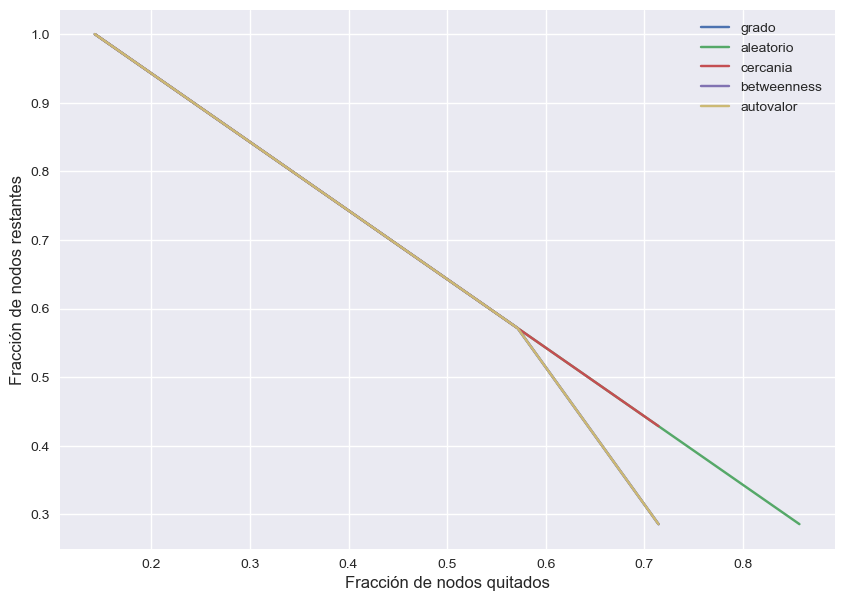

In [45]:
plt.figure(figsize=(10,7))
for i in range(len(quitados)):
    plt.style.use('seaborn')
    plt.plot(quitados[i], restantes[i], label = str((lista_metodos[i]).__name__[6:]))
    plt.legend()
    plt.xlabel('Fracción de nodos quitados', fontsize = 12)
    plt.ylabel('Fracción de nodos restantes', fontsize = 12)

### Histogramas por centralidad

centralidad a cada nodo de la subred y ese valor se lo meto a la red entera
me qudo con el porcentaje arbitrario de los mas altos de toda esa red nueva

Analisis:

Calculo centralidad con cada metodo y me quedo con mismo porcentaje


In [82]:
## Quiero usar los distintos algoritmos de centralidad y tomar el valor de cada nodo dado por cada uno de los algoritmos

def centralidad_nodos(Red):
    
	diccionario_grado = dict(Red.degree())
	diccionario_cercania = nx.closeness_centrality(Red, u=None, distance='weight', wf_improved=True)
	diccionario_betweenness = nx.betweenness_centrality(Red, weight='weight')
	diccionario_autovalor = nx.eigenvector_centrality(Red, max_iter=5000, tol=1e-06, nstart=None, weight='weight')
	
	return diccionario_grado, diccionario_cercania, diccionario_betweenness, diccionario_autovalor

def armar_tabla_centralidad(Red):

	diccionario_grado, diccionario_cercania, diccionario_betweenness, diccionario_autovalor = centralidad_nodos(Red)

	tabla = pd.DataFrame(columns = ['Nodo', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])
	for nodo in Red.nodes():
		df = pd.DataFrame({'Nodo' : nodo, 'Grado' : diccionario_grado[nodo], 'Cercanía' : diccionario_cercania[nodo], 
						   'Betweenness' : diccionario_betweenness[nodo], 'Autovalor' : diccionario_autovalor[nodo]}, index=[0])
		tabla = pd.concat([tabla, df])
	tabla = tabla.reset_index(drop=True)
	return tabla

In [83]:
tabla1

Comunidad Nodos Enlaces Grado promedio Coeficiente de clustering
0          0   117     232       3.965812                  0.428597
1          1   124    2282      36.806452                  0.700416
2          2    47     157       6.680851                  0.720391
3          3     2       1            1.0                       0.0
4          4   109     866      15.889908                  0.651481
5          5    62     609      19.645161                  0.736784
6          6    85     313       7.364706                  0.611056
7          7    61     283       9.278689                  0.673296
8          8    47     324      13.787234                  0.801323
9          9    51     507      19.882353                  0.880258
10        10    25      76           6.08                  0.542896
11        11    21      80       7.619048                  0.725833
12        12    64     532         16.625                  0.707126
13        13     6      13       4.333333                       0.9
14        14     3       2       1.333333                       0.0
15        15    48     174           7.25                  0.705606
16        16     4       4            2.0                  0.583333
17        17    29     267      18.413793                  0.862072
18        18    50     408          16.32                  0.809206
19        19    30     310      20.666667                  0.918524
20        20     2       1            1.0                       0.0
21        21    10      44            8.8                  0.977778
22        22     7      21            6.0                       1.0

In [84]:
tabla_centralidades = pd.DataFrame(columns = ['Nodo', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])

grafitos = sorted(list(glob.glob('../../Datos/subgrafos/Gigante_06/subgrafo_comunidad_*.graphml')))

grafitos_ordenados = sorted(grafitos, key=lambda x: int(x.split('_comunidad_')[1].split('.')[0]))

for grafo in grafitos_ordenados:
	Red = nx.read_graphml(grafo)
	tabla_aux = armar_tabla_centralidad(Red)
	tabla_centralidades = pd.concat([tabla_centralidades, tabla_aux])
	tabla_centralidades = tabla_centralidades.reset_index(drop=True)

In [85]:
tabla_centralidades

Nodo Grado  Cercanía Betweenness Autovalor
0     YBR196C     4  0.211679    0.003503  0.000684
1     YDR238C     7  0.150065    0.000155  0.324401
2     YMR012W     4  0.226121     0.02067  0.000289
3     YDR214W     1  0.204405         0.0  0.000064
4     YDR328C     3  0.146465    0.050825  0.000003
...       ...   ...       ...         ...       ...
999   YDL051W     6       1.0    0.011111  0.360765
1000  YPR088C     6       1.0    0.011111  0.360765
1001  YPL243W     6       1.0    0.011111  0.360765
1002  YPL210C     6       1.0    0.011111  0.360765
1003  YDL092W     6  0.857143         0.0  0.417878

[1004 rows x 5 columns]

In [276]:
# tabla_centralidades.sort_values(by = 'Betweenness', ascending = False)

In [100]:
## defino el porcentaje mayor de valores, es decir me quedo con el 10% de los nodos con mayor valor de cada centralidad

def porcentaje_mayor_valores_javi(tabla, centralidad, porcentaje):
	tabla_ordenada = tabla.sort_values(by = [centralidad], ascending = False)
	numeros_ordenados = tabla_ordenada[centralidad]
	valor_cota = max(numeros_ordenados) - ((max(numeros_ordenados) - min(numeros_ordenados))*porcentaje)
	print(valor_cota)
	tt = tabla_ordenada[tabla_ordenada[centralidad] >= valor_cota].copy()
	
	return tt[['Nodo', centralidad]]

In [96]:
## defino el porcentaje mayor de valores, es decir me quedo con el 10% de los nodos con mayor valor de cada centralidad

def porcentaje_mayor_valores(tabla, centralidad, porcentaje):
	tabla_ordenada = tabla.sort_values(by = [centralidad], ascending = False)
	numeros_ordenados = tabla_ordenada[centralidad]
	valor_cota = max(numeros_ordenados) - ((max(numeros_ordenados) - min(numeros_ordenados))*porcentaje)
	
	tabla_ordenada = tabla_ordenada.reset_index(drop=True)
	cantidad = int(len(tabla_ordenada)*porcentaje)

	return tabla_ordenada[['Nodo', centralidad]][:cantidad]

In [98]:
tabla_porcentaje = porcentaje_mayor_valores(tabla_centralidades, 'Grado', 0.1)
tabla_porcentaje

Nodo Grado
0   YOL127W    79
1   YGR085C    79
2   YDR447C    78
3   YOR063W    77
4   YML073C    77
..      ...   ...
95  YLR186W    34
96  YOL077C    33
97  YOR206W    33
98  YPL211W    33
99  YDL030W    33

[100 rows x 2 columns]

In [101]:
porcentaje_mayor_valores_javi(tabla_centralidades, 'Grado', 0.1)

71.2


Nodo Grado
232   YOL127W    79
179   YGR085C    79
120   YDR447C    78
193   YOR063W    77
199   YML073C    77
204   YJR123W    76
140  YFR031CA    76
230   YML063W    75
158   YMR242C    75
123   YGL103W    74
142   YNL069C    74
156   YJL177W    74
169   YKL180W    73
224   YDR471W    73
229   YOR096W    72

In [340]:
# plt.plot(tabla_centralidades['Betweenness'], 'o')
# plt.axhline(71, ls = '--', color = 'k')

In [65]:
## Quiero calcular el accuaracy para cada centralidad 
def calcular_accuracy(tabla, lista_esenciales, porcentaje):
	keys = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']
	accuracy = {keys[0]:[], keys[1]:[], keys[2]:[], keys[3]:[]}

	for centralidad in keys:
		
		tabla_porcentaje = porcentaje_mayor_valores(tabla, centralidad, porcentaje)

		nodos_en_tabla = set(tabla_porcentaje['Nodo'])
		esenciales_en_tabla = [nodo for nodo in nodos_en_tabla if nodo in lista_esenciales]

		cantidad_escenciales = len(lista_esenciales)
	
		exactitud = len(esenciales_en_tabla)/cantidad_escenciales * 100
		accuracy[centralidad] = exactitud
		
	return accuracy

In [87]:

porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
# porcentaje = [0.5]

accuracy_df = pd.DataFrame(columns = ['Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])

for porc in porcentaje:
	accuracy = calcular_accuracy(tabla_centralidades, lista_esenciales, porc)
	df = pd.DataFrame({'Porcentaje' : str(int(porc*100))+'%', 'Grado' : accuracy['Grado'], 'Cercanía' : accuracy['Cercanía'], 
					   'Betweenness' : accuracy['Betweenness'], 'Autovalor' : accuracy['Autovalor']}, index=[0])
	accuracy_df = pd.concat([accuracy_df, df])

# accuracy = calcular_accuracy(tabla_centralidades, lista_esenciales)
# pd.DataFrame.from_dict(accuracy, orient='index', columns = ['Exactitud'])
accuracy_df = accuracy_df.reset_index(drop=True)
accuracy_df

Porcentaje      Grado   Cercanía Betweenness  Autovalor
0         5%   0.951557   1.816609    2.249135   2.595156
1        10%   3.719723   2.768166    4.065744   5.622837
2        15%   7.179931    4.32526    6.747405   8.131488
3        20%   9.429066   6.747405    8.823529  10.640138
4        25%  11.937716   8.477509   10.813149  13.408304
5        30%  13.754325  11.245675   12.629758  15.397924
6        35%  16.262976   13.84083   14.273356  17.387543
7        40%  19.290657  16.695502   17.041522  19.463668
8        45%  21.972318  19.117647     18.3391  21.366782
9        50%  23.096886  22.058824   20.847751  23.529412

In [59]:
len([nodo for nodo in set(tabla_centralidades['Nodo']) if nodo in lista_esenciales])

607